## Importing dataset of image information:

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import resnet50
from PIL import Image
from numpy import asarray

import random
import os
import pandas as pd
import numpy as np
from skimage.io import imread_collection
import skimage.io
import skimage.color
import skimage.transform
from platform import python_version
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

print(tf.__version__)
print(python_version())

Using TensorFlow backend.


1.14.0
3.6.6


In [2]:
# extract filenames from the folder of images
filenames = []
for root, dirs, files in os.walk('../input/rsna-hemorrhage-jpg/train_jpg/train_jpg'):
    for file in files:
        if file.endswith('.jpg'):
            filenames.append(file)

print("Total images in Jeremy Howard's metatable: "+"{}".format(len(filenames)))

Total images in Jeremy Howard's metatable: 194082


## Cleaning and splitting the dataset of image information:
Get a dataset of only images with 3+ hemorrhages types (6,547) and 20,000 random healthy images.

In [3]:
labels = pd.read_feather('../input/rsna-hemorrhage-jpg/meta/meta/labels.fth')

#manipulate the filenames list, stripping the .jpg at the end
idstosearch = [item.rstrip(".jpg") for item in filenames]

#now search the "ID" column for ids that correspond to our filenames
labels = labels[labels['ID'].isin(idstosearch)]

/opt/conda/lib/python3.6/site-packages/pandas/io/feather_format.py:117: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_feather(path, columns=columns, nthreads=int_use_threads)
/opt/conda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
random.seed(10)
new_hem = labels[labels[['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum(1) >= 3].copy()
new_normal = labels[labels['any'] == 0].copy()
new_normal = new_normal.sample(n = 20000)
frames = [new_normal, new_hem]
new = pd.concat(frames)
new = new.sort_values('ID')
print("Number of images with hemorrhage: "+"{}".format(len(new_hem)))
print("Number of healthy images: "+"{}".format(len(new_normal)))
print("Percent of dataset with 3+ hemorrhage types: "+"{:.2%}".format(len(new_hem)/len(new)))

Number of images with hemorrhage: 6547
Number of healthy images: 20000
Percent of dataset with 3+ hemorrhage types: 24.66%


## Image import:
Import photos using their ID names drawn from the train and test datasets. These images come from Jeremy Howard's [dataset](http://www.kaggle.com/jhoward/rsna-hemorrhage-jpg) of ~200,000 images.

In [5]:
new, test = train_test_split(new, test_size = 0.1)
newlist = new['ID']
newids = ["../input/rsna-hemorrhage-jpg/train_jpg/train_jpg/"+ x + ".jpg" for x in newlist]
newimages = imread_collection(newids)

labels_new = new.iloc[:, 1]
print("Percent train images hemorrhage positive: "+"{:.2%}".format(labels_new.sum()/len(new)))

testlist = test['ID']
testids = ["../input/rsna-hemorrhage-jpg/train_jpg/train_jpg/"+ x + ".jpg" for x in testlist]
testimages = imread_collection(testids)

labels_test = test.iloc[:, 1]
print("Percent test images hemorrhage positive: "+"{:.2%}".format(labels_test.sum()/len(test)))

Percent train images hemorrhage positive: 24.73%
Percent test images hemorrhage positive: 24.03%


In [6]:
labels_new = pd.Series.to_numpy(labels_new)
newimages_arr = skimage.io.collection.concatenate_images(newimages)
labels_test = pd.Series.to_numpy(labels_test)
testimages_arr = skimage.io.collection.concatenate_images(testimages)

## Model training:

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(256, 256, 3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
model.compile(optimizer=keras.optimizers.Adadelta(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(newimages_arr, labels_new, epochs = 50, validation_split = 0.1)

Train on 21502 samples, validate on 2390 samples
Epoch 1/50
21502/21502 [==============================] - 12s 558us/sample - loss: 10.0205 - acc: 0.7419 - val_loss: 5.2488 - val_acc: 0.7770
Epoch 2/50
21502/21502 [==============================] - 11s 516us/sample - loss: 5.2469 - acc: 0.7832 - val_loss: 6.8900 - val_acc: 0.7841
Epoch 3/50
21502/21502 [==============================] - 11s 513us/sample - loss: 3.9191 - acc: 0.8036 - val_loss: 3.6865 - val_acc: 0.7682
Epoch 4/50
21502/21502 [==============================] - 11s 512us/sample - loss: 2.9297 - acc: 0.8035 - val_loss: 1.8868 - val_acc: 0.8004
Epoch 5/50
21502/21502 [==============================] - 11s 515us/sample - loss: 1.2574 - acc: 0.8075 - val_loss: 1.0327 - val_acc: 0.8205
Epoch 6/50
21502/21502 [==============================] - 11s 513us/sample - loss: 1.0000 - acc: 0.8225 - val_loss: 1.3800 - val_acc: 0.8117
Epoch 7/50
21502/21502 [==============================] - 11s 512us/sample - loss: 0.9096 - acc: 0.8309 

## Model summary:

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               25165952  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 25,166,081
Trainable params: 25,166,081
Non-trainable params: 0
_________________________________________________________________


## Model metrics:

In [11]:
import sklearn.metrics as metrics
predictions = model.predict(testimages_arr)

test_loss, test_acc = model.evaluate(testimages_arr, labels_test, verbose=2)
print("Test Accuracy: "+"{:.2%}".format(test_acc))

2655/2655 - 1s - loss: 0.8293 - acc: 0.8411
Test Accuracy: 84.11%


In [12]:
mse = metrics.mean_squared_error(predictions.flatten(), labels_test)
print("Test MSE: "+"{:.3}".format(mse))

Test MSE: 0.137


Test AUC: 0.902


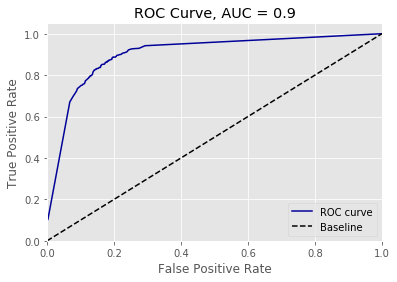

In [13]:
def get_statistics(preds, test, threshold):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for i in range(0, len(test)):
        if test[i] == 1 and preds[i] >= threshold:
            tp += 1
        elif test[i] == 1 and preds[i] < threshold:
            fn += 1
        elif test[i] == 0 and preds[i] >= threshold:
            fp += 1
        elif test[i] == 0 and preds[i] < threshold:
            tn += 1

    return (tp, fp, tn, fn)

tpr = []
fpr = []
thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    # DNN
    (tp, fp, tn, fn) = (0, 0, 0, 0)
    (tp_s, fp_s, tn_s, fn_s) = get_statistics(preds=predictions.flatten(), test=labels_test, threshold=threshold)

    tp += tp_s
    fp += fp_s
    tn += tn_s
    fn += fn_s

    try:
        #print("Threshold: {} has TPR: {}".format(threshold, float(tp) / (tp + fn)))
        tpr.append(float(tp) / (tp + fn))
    except:
        #print("Threshold: {} has TPR: {}".format(threshold, 0))
        tpr.append(0)

    try:
        #print("Threshold: {} has FPR: {}".format(threshold, float(fp) / (fp + tn)))
        fpr.append(float(fp) / (fp + tn))

    except:
        #print("Threshold: {} has FPR: {}".format(threshold, 0))
        fpr.append(0)

auc = metrics.auc(fpr, tpr)
title = 'ROC Curve, AUC = {:.2}'.format(auc)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "#000099", label='ROC curve')
    ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title(title)
    
print("Test AUC: "+"{:.3}".format(auc))